# Plotting

This notebook will describe how to visualize data using GrandPy in different scenarios. In addition to QC plots (see the [differential expression](../notebook_01_differential_expression.ipynb) and [kinetic modeling](../notebook_02_kinetic_modeling.ipynb) notebooks) and vulcano/MA plots (see the [differential expression](../notebook_01_differential_expression.ipynb) notebook), the plotting functions in GrandPy consist of:

- Gene-wise visualizations
- Global visualizations (scatter plots, heatmaps)

# Gene-wise visualization

All functions that visualize data for a single gene start with `plot_gene_...`. We demonstrate the first few using the [BANP data set](https://www.nature.com/articles/s41586-021-03689-8). These are SLAM-seq data from multiple time points (1h, 2h, 4h, 6h and 20h) after acute depletion of BANP. We first load and preprocess this data as usual:

In [1]:
import warnings
import pandas as pd
from scripts.regsetup import description

import grandpy as gp
from grandpy import ModeSlot, plot_scatter

warnings.filterwarnings("ignore", category=UserWarning)

banp = gp.read_grand("https://zenodo.org/record/6976391/files/BANP.tsv.gz", design=("Cell", "Experimental.time", "Genotype", "duration.4sU", "has.4sU", "Replicate"))

Detected URL -> downloading to temp file
Detected dense format -> using dense reader
Temporary file BANP.tsv.gz was deleted after loading.


In [2]:
banp = banp.filter_genes()
banp = banp.normalize()

Refer to the [loading data](../notebook_03_loading_data_and_working_with_grandpy_objects.ipynb) notebook to learn more about how to load data.

The most basic plots are just showing the raw data (from the defualt slot, by default shown in log scale, both can be changed via parameters):

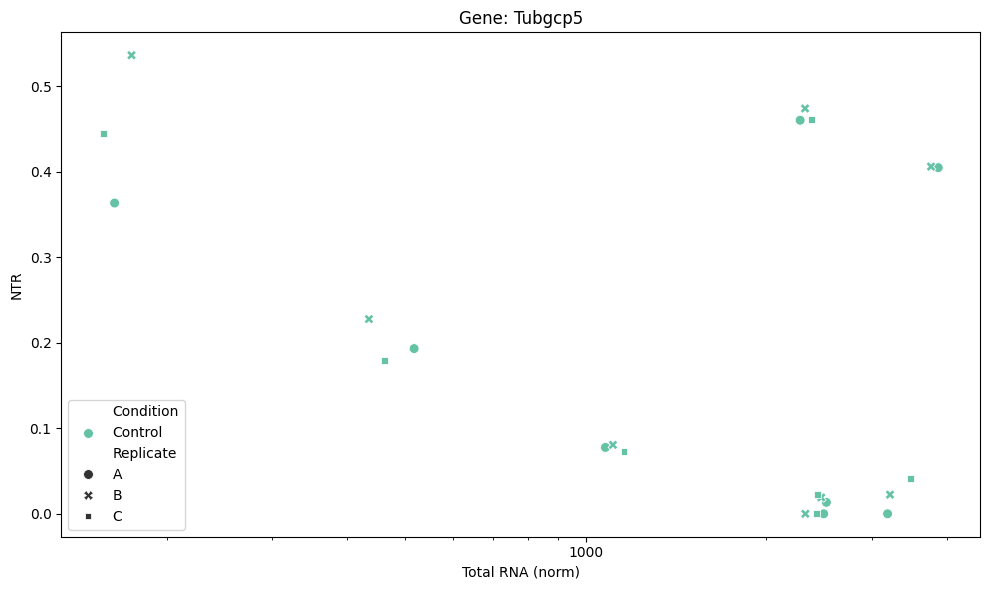

In [3]:
gp.plot_gene_total_vs_ntr(banp, gene = "Tubgcp5")

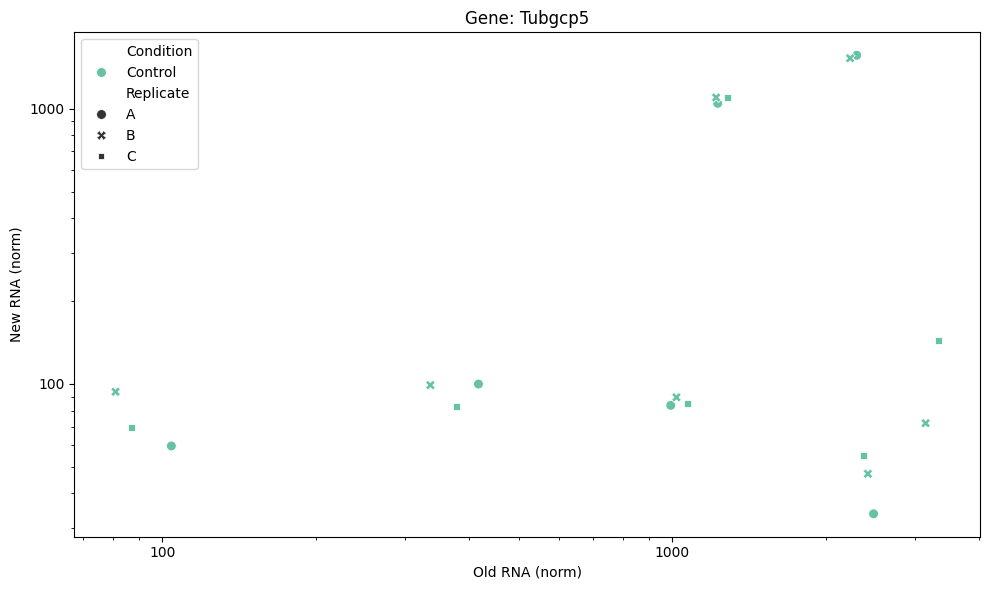

In [4]:
gp.plot_gene_old_vs_new(banp,gene = "Tubgcp5")

By defualt replicates (if present in the `Coldata` table) will be shown as the point shapes, and conditions as colors. Here we do not have a Condition, so let's add this (and show only the new vs. old plot, as this works the same way for the total vs. NTR):

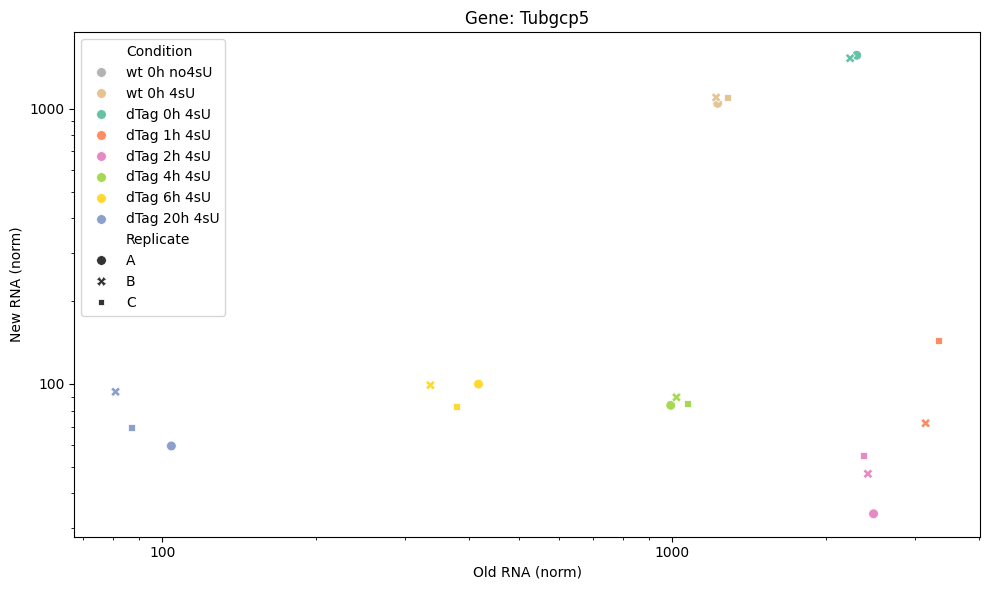

In [5]:
banp = banp.with_condition(value = ["Genotype", "Experimental.time.original", "has.4sU"])
gp.plot_gene_old_vs_new(banp, gene = "Tubgcp5")

To change the aesthetic mappings we use the `aest` parameter as follows:

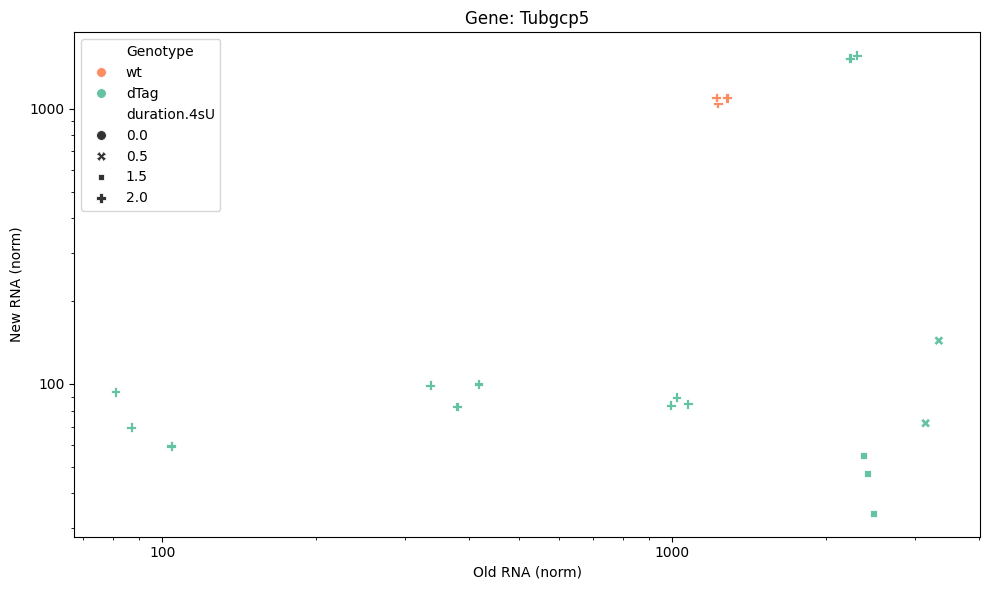

In [6]:
gp.plot_gene_old_vs_new(banp, "Tubgcp5", aest={"color": "Genotype", "shape": "duration.4sU"})

Both plotting functions also offer to plot credible intervals. These must be precomputed using `compute_ntr_ci`.

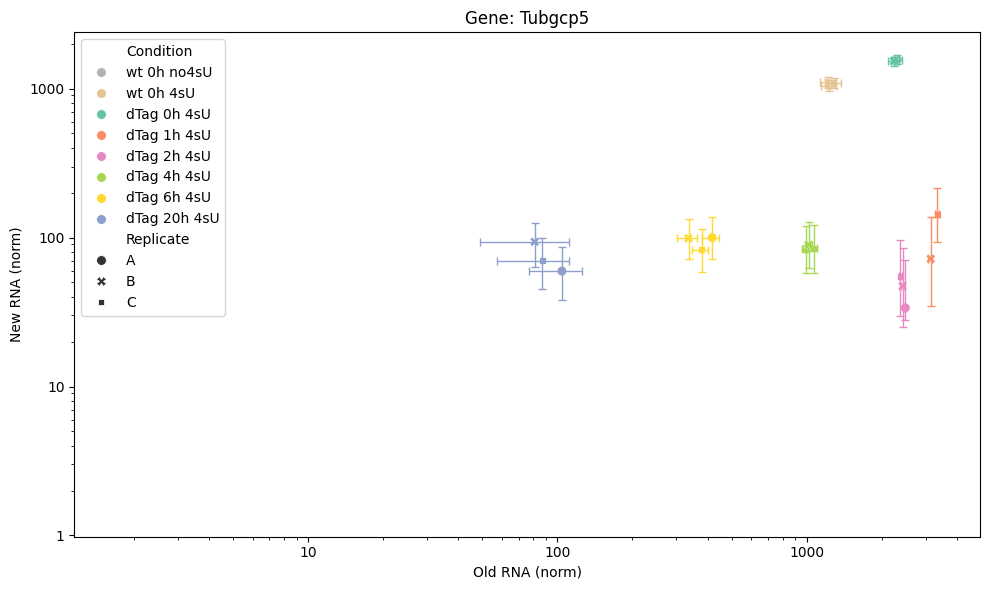

In [7]:
banp = banp.compute_ntr_ci()
gp.plot_gene_old_vs_new(banp, "Tubgcp5", show_ci=True)

These visualizations are sometimes hard to interpret. In such situations, it makes sense to only plot either old, new or total RNA on the y axis, and group samples on the x axis. By default, `plot_gene_groups_points` will group the points according to the Condition (which can be changed via the group parameter). To demonstrate, we plot new RNA from the norm slot:

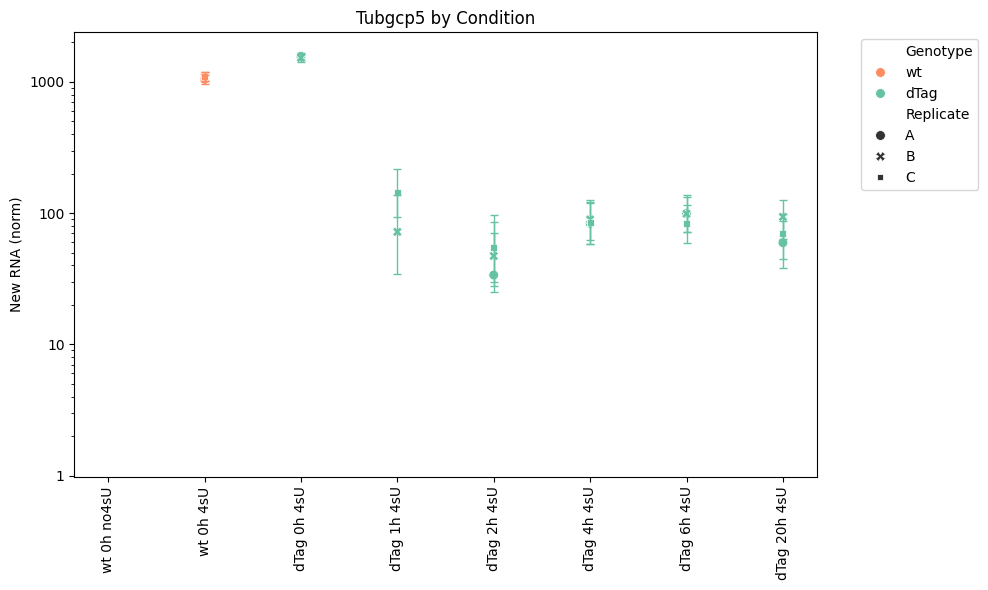

In [8]:
gp.plot_gene_groups_points(banp, "Tubgcp5", mode_slot="new_norm", show_ci=True, aest={"color": "Genotype"})
#TODO Hier noch falls Zeit einen dodgeparameter hinzufügen falls man cis benutzt...

The last of the basic visualizations shows old (gray) and new (red) RNA as bars (and here we change the way the samples are labeled on the x axis):

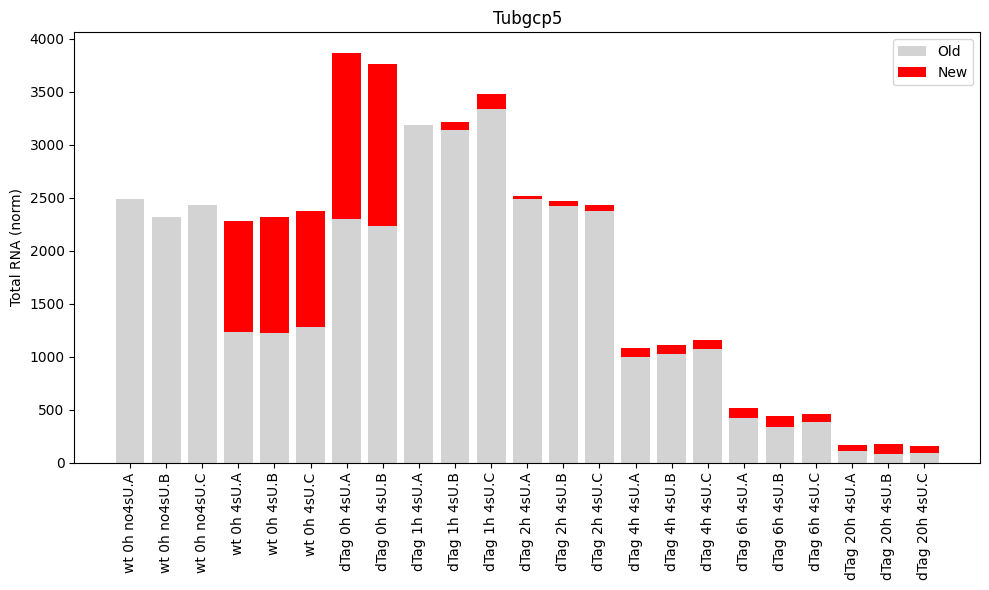

In [9]:
gp.plot_gene_groups_bars(banp, "Tubgcp5", x_labels="Condition + '.' + Replicate")

GrandPy also provides more sophisticated plotting function for time courses. A time course can either consist of several snapshots or it can be a progressive labeling time course (i.e. labeling was started at the same time point for each sample, or, in other words, the experimental time is equal to the labeling time). For snapshot data, we can use the `plot_gene_snapshot_timecourse` function. This function will plot time course per condition, and right now each time point belongs to its own condition as defined above. Thus, we will just remove the condition for now. Furthermore, the wt Genotype doesn’t have annotated experimental times, so we remove these samples as well:

In [10]:
banp = banp[:, banp.coldata["Genotype"] == "dTag"]
banp = banp.with_condition(None)

For `plot_gene_snapshot_timecourse` we need to define the time parameter corresponding to the experimental time, which is here the time since depleting BANP:

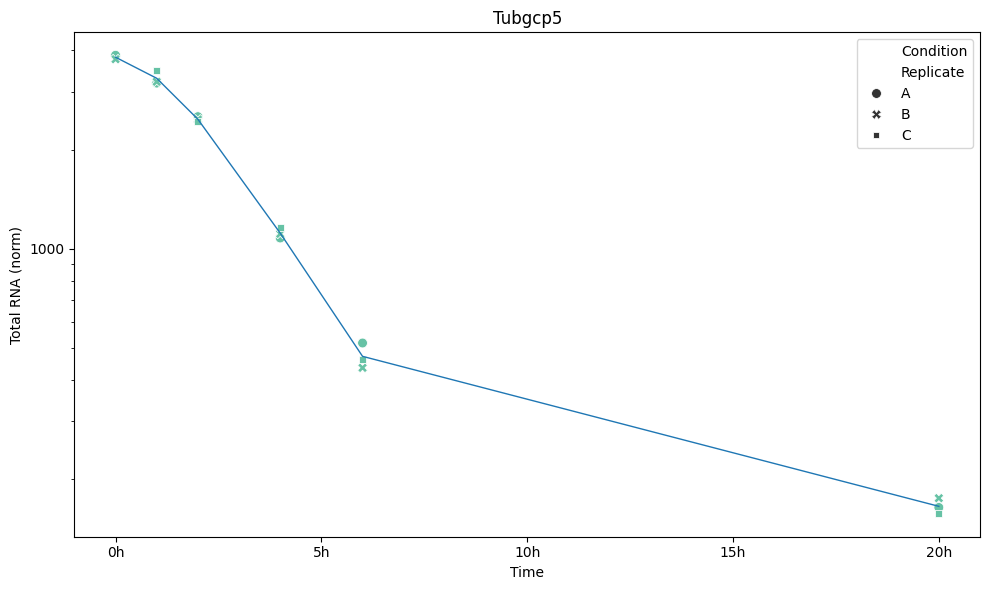

In [11]:
gp.plot_gene_snapshot_timecourse(banp, "Tubgcp5", time="Experimental.time")

We can also change this to not plot in log scale, plot new RNA and show credible intervals:

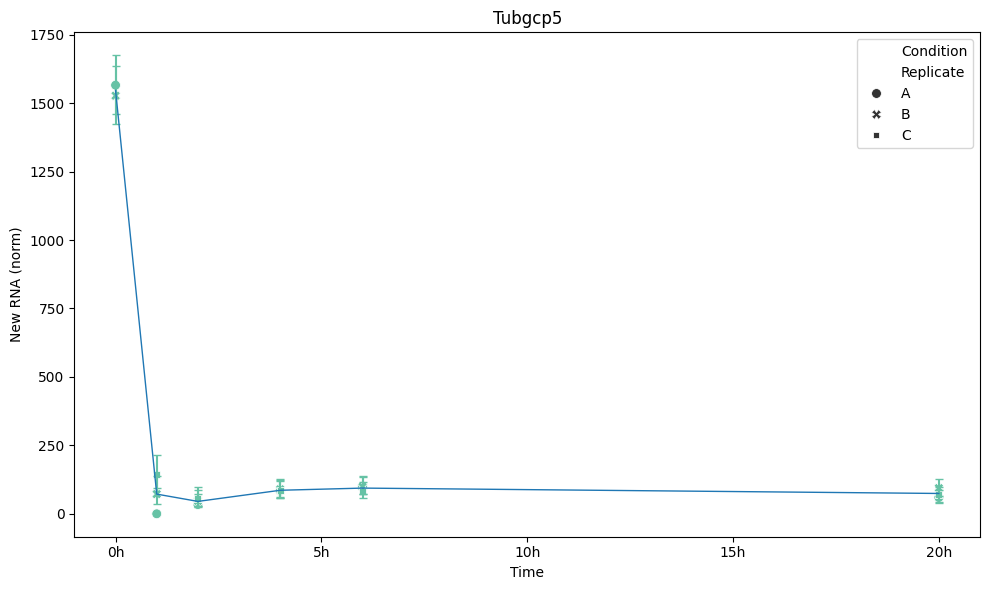

In [12]:
gp.plot_gene_snapshot_timecourse(banp, "Tubgcp5", time="Experimental.time", log=False, mode_slot="new_norm", show_ci=True)

If you have multiple conditions, it will automatically show them as colors (here we don’t have conditions, so we just treat the replicates as separate conditions; we also show the NTR instead of new RNA):

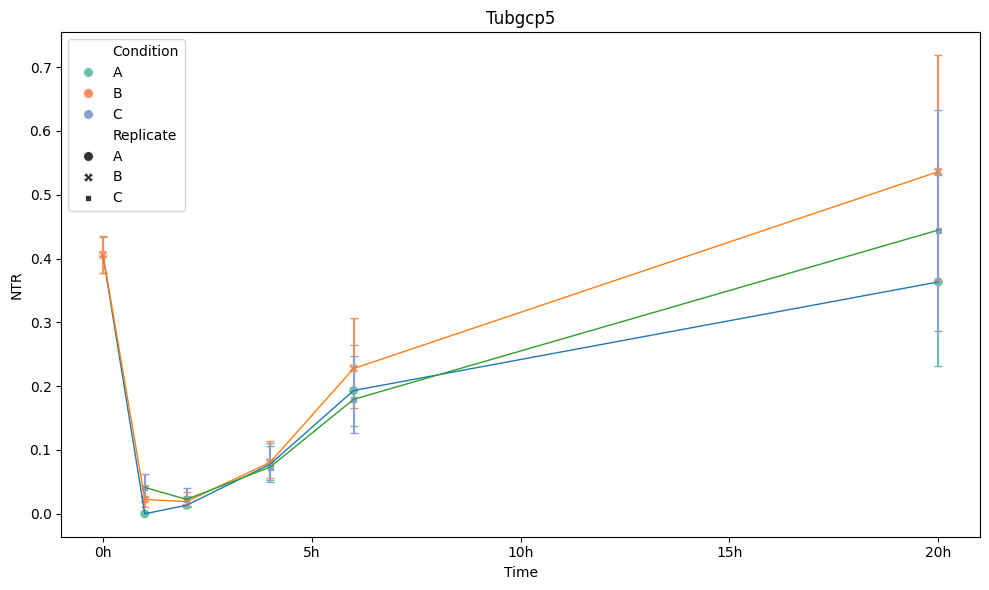

In [13]:
banp = banp.with_condition("Replicate")
gp.plot_gene_snapshot_timecourse(banp, "Tubgcp5", time="Experimental.time", mode_slot="ntr", show_ci=True)


These data consist of a timecourse of several snapshots. There is also another kind of timecourse: progressive labeling. This means that the 2h time point also had 2h of labeling, and the 4h timepoint had 4h of labeling etc. Such data can be visualized using `plot_gene_progressive_timecourse`. To demonstrate this, we first load and process the data set from [[Finkel et al. (2021)]](https://www.nature.com/articles/s41586-021-03610-3). The data set contains time series (progressive labeling) samples from a human epithelial cell line (Calu3 cells); half of the samples were infected with SARS-CoV-2 for different periods of time.

In [14]:
sars = gp.read_grand("https://zenodo.org/record/5834034/files/sars.tsv.gz", design=("Condition", "dur.4sU", "Replicate"), classify_genes_func=lambda df: gp.classify_genes(df, cg_name="Viral"))

Detected URL -> downloading to temp file
Detected dense format -> using dense reader
Temporary file sars.tsv.gz was deleted after loading.


In [15]:
sars = sars.filter_genes().normalize().compute_ntr_ci()

Now we can use it to plot time courses. The function will use the `Condition` field and generate a plot for each condition. Just like above, here we will also plot credible intervals of the NTR quantification. In addition to data points, the plotting function will also show the model fit. For that to work, here it is important to specify the steady state parameters. For more on this, see the kinetic modeling notebook.
#TODO kinetic modeling verlinken

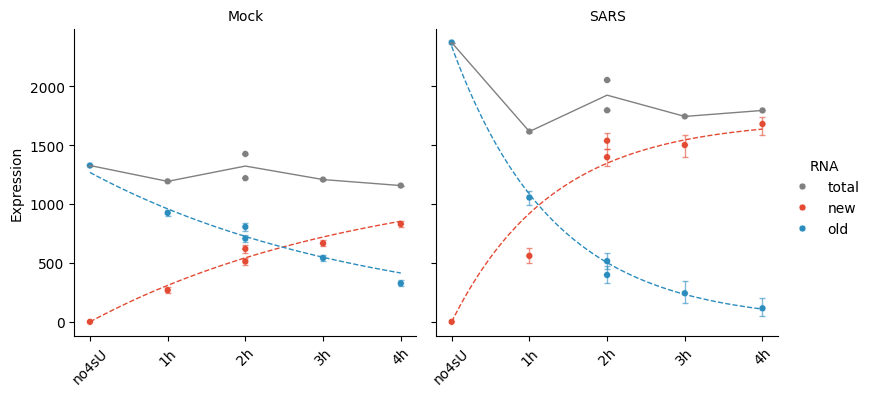

In [16]:
gp.plot_gene_progressive_timecourse(sars, "SRSF6", show_ci = True, steady_state={"Mock": True,"SARS": False})

We can also fit the kinetic model using the Bayesian method (which inherently assumes steady state, and actually is not appropriate for the “SARS” condition). Note that the visualization changes to indicate that this method does not use the quantification of RNA abundances at all.

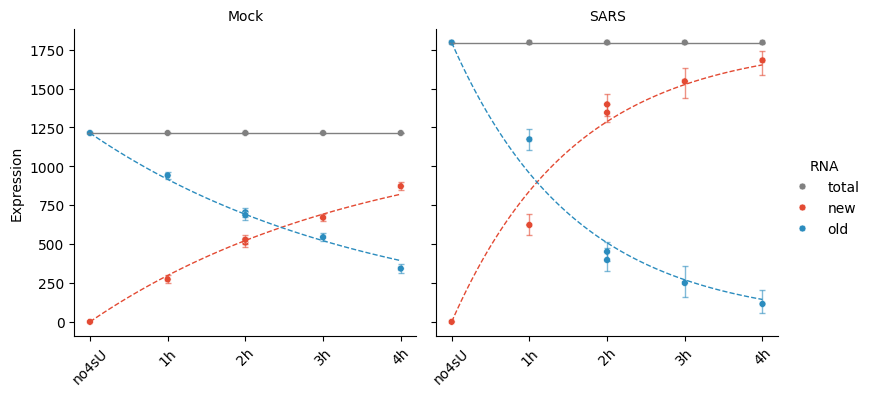

In [17]:
gp.plot_gene_progressive_timecourse(sars, "SRSF6", fit_type="ntr", show_ci = True)

Note that the SARS condition, which is not at steady state, is not fit well.

# Global visualtizations

GrandPy implements two convenience functions to create (i) scatter plots and (ii) heat maps from GrandPy data.

# ScatterPlot

Scatter plots are frequently used to provide a global overview over two variables. A straight-forward example is to compare expression values from two samples (i.e., here the x and y parameters are sample names from the data set):

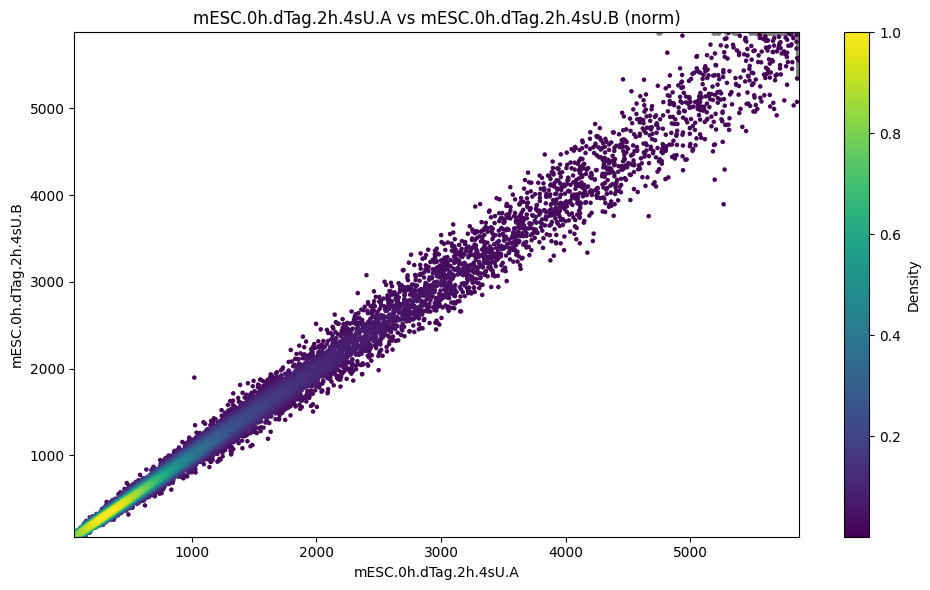

In [18]:
gp.plot_scatter(banp, x="mESC.0h.dTag.2h.4sU.A",y="mESC.0h.dTag.2h.4sU.B")

Note that `plot_scatter` automatically cuts outliers (shown at the upper right corner in gray) to focus on the bulk of the genes (see below how to modify this behavior), and that it shows dense regions (with many genes) by brighter colors.

`plot_scatter` can also display results from analyses (see the differential expression and kinetic modeling vignettes for more information on analyses). To demonstrate, we first create some analyses results:
#TODO verlinkungen von diffexp und kinetic modeling

In [19]:
#TODO Ab hier geht irgendwa schief es gibt keine analysen nach stunden sondern nur new und total
print(banp.coldata)
contrasts = banp.get_contrasts(contrast=["Experimental.time.original", "0h"])
banp = banp.compute_lfc(name_prefix="total", contrasts=contrasts)
banp = banp.pairwise_deseq2(name_prefix="total", contrasts=contrasts)

                                                  Name  Cell  \
Name                                                           
mESC.0h.dTag.2h.4sU.A            mESC.0h.dTag.2h.4sU.A  mESC   
mESC.0h.dTag.2h.4sU.B            mESC.0h.dTag.2h.4sU.B  mESC   
mESC.1h.dTag.30min.4sU.A      mESC.1h.dTag.30min.4sU.A  mESC   
mESC.1h.dTag.30min.4sU.B      mESC.1h.dTag.30min.4sU.B  mESC   
mESC.1h.dTag.30min.4sU.C      mESC.1h.dTag.30min.4sU.C  mESC   
mESC.2h.dTag.90min.4sU.A      mESC.2h.dTag.90min.4sU.A  mESC   
mESC.2h.dTag.90min.4sU.B      mESC.2h.dTag.90min.4sU.B  mESC   
mESC.2h.dTag.90min.4sU.C      mESC.2h.dTag.90min.4sU.C  mESC   
mESC.4h.dTag.120min.4sU.A    mESC.4h.dTag.120min.4sU.A  mESC   
mESC.4h.dTag.120min.4sU.B    mESC.4h.dTag.120min.4sU.B  mESC   
mESC.4h.dTag.120min.4sU.C    mESC.4h.dTag.120min.4sU.C  mESC   
mESC.6h.dTag.120min.4sU.A    mESC.6h.dTag.120min.4sU.A  mESC   
mESC.6h.dTag.120min.4sU.B    mESC.6h.dTag.120min.4sU.B  mESC   
mESC.6h.dTag.120min.4sU.C    mESC.6h.dTa

Running Wald tests...


Log2 fold change & Wald test p-value: comparison 1 vs 2
           baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0        182.855929        0.503154  0.177442  2.835595  4.574041e-03   
1        257.564357       -0.645297  0.149814 -4.307320  1.652447e-05   
2        303.487928        0.582767  0.145016  4.018653  5.853186e-05   
3        926.114075        0.323837  0.103031  3.143114  1.671606e-03   
4        790.184431        0.398537  0.110110  3.619439  2.952425e-04   
...             ...             ...       ...       ...           ...   
11091  29325.817629       -0.718296  0.107646 -6.672765  2.510285e-11   
11092   1570.871791       -0.271774  0.097491 -2.787685  5.308618e-03   
11093   6855.419536       -0.664861  0.084093 -7.906275  2.652054e-15   
11094   2141.716597        0.064291  0.102060  0.629931  5.287400e-01   
11095   9475.176345       -0.294745  0.077323 -3.811868  1.379203e-04   

               padj  
0      1.497155e-02  
1      1.004138e-04  
2

... done in 0.65 seconds.



In [20]:
banp = banp.compute_lfc(name_prefix="new", contrasts=contrasts, mode_slot="new_norm", normalization="total")
banp = banp.pairwise_deseq2(name_prefix="new", contrasts=contrasts, mode_slot="new_norm", normalization="total")

C:\Users\Andre\PycharmProjects\grandpy\grandpy\lfc.py:34: RuntimeWarning: divide by zero encountered in log
  diff = np.log(A0) - np.log(B0)


Using parametric fit type.


Running Wald tests...


Log2 fold change & Wald test p-value: comparison 1 vs 2
          baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0        71.237684       -0.127495  0.390943 -0.326121  7.443328e-01   
1        35.548632       -1.717702  0.501007 -3.428500  6.069262e-04   
2       168.028416        0.425014  0.247746  1.715527  8.624871e-02   
3       373.032524        0.485337  0.166787  2.909926  3.615141e-03   
4        67.284500        0.841359  0.383474  2.194044  2.823223e-02   
...            ...             ...       ...       ...           ...   
11091  5461.256078       -0.873130  0.089925 -9.709513  2.746451e-22   
11092   127.480041       -0.229316  0.285407 -0.803470  4.217032e-01   
11093   960.070214       -0.747852  0.144477 -5.176282  2.263518e-07   
11094  1715.712242        0.031330  0.105221  0.297754  7.658906e-01   
11095  1787.133783       -0.311264  0.096778 -3.216264  1.298713e-03   

               padj  
0      8.639243e-01  
1      3.980173e-03  
2      2.1075

... done in 0.64 seconds.



In [21]:
banp.get_analyses()

banp.get_analysis_table("total_A vs B_LFC")

#gp.plot_scatter(banp, x="total_A vs B_LFC", y="new_A vs B_LFC", remove_outlier=False)

,Symbol,Gene,Length,Type
Symbol,,,,
Crispld1,Crispld1,ENSMUSG00000025776,4472,Cellular
Gsta3,Gsta3,ENSMUSG00000025934,2792,Cellular
Paqr8,Paqr8,ENSMUSG00000025931,5330,Cellular
Tmem70,Tmem70,ENSMUSG00000025940,1710,Cellular
Des,Des,ENSMUSG00000026208,3028,Cellular
...,...,...,...,...
Huwe1,Huwe1,ENSMUSG00000025261,14579,Cellular
Hsd17b10,Hsd17b10,ENSMUSG00000025260,1001,Cellular
Smc1a,Smc1a,ENSMUSG00000041133,4691,Cellular
